1.New York Taxis:

1.0.1 Goal and description (describir objetivo y description del proyecto)

1.0.2 Step 1. Imports and loading datasets

In [1]:
# Import packages

# data manipulation packages
import numpy as np
import pandas as pd

# data visualization packages
from matplotlib import pyplot as plt
import seaborn as sns

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

# For data modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import re #re module, which provides regular expression functionalities. Regular expressions are a powerful tool for searching and manipulating text based on patterns.

In [2]:
# Load dataset into a dataframe
taxi_df = pd.read_csv('Taxi_dataset.csv', low_memory=False)

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [3]:
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.2,1.0,N,238.0,239.0,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.2,1.0,N,239.0,238.0,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.6,1.0,N,238.0,238.0,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.8,1.0,N,238.0,151.0,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.0,1.0,N,193.0,193.0,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


1.0.3 Step 2. Data Exploration (Initial EDA and data cleaning)

In [4]:
taxi_df.shape

(11916667, 18)

As we can see using the shape function the data almost have 12 million rows. If there is a possibility of filtering the data and use less of it we will do it. In order to check this we will look at 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' variables. 

In [5]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11916667 entries, 0 to 11916666
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               object 
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           float64
 8   DOLocationID           float64
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(14), object(4)
memory usage: 1.6+ GB


First thing we have encountered is that pickup and dropoff are not datetime type variables. In order to be able to work with them and filter the data we need to transform them into datetime variables.

In [6]:
taxi_df['tpep_pickup_datetime'].head()

0    01/01/2020 12:28:15 AM
1    01/01/2020 12:35:39 AM
2    01/01/2020 12:47:41 AM
3    01/01/2020 12:55:23 AM
4    01/01/2020 12:01:58 AM
Name: tpep_pickup_datetime, dtype: object

In order to transform the variable into datetime we need to know what is the string format. Using head() we saw that we were not able to see if first and second position of the string corresponded to days or months and what type of hour clock it used. By using iloc[ ] and selecting a random number we can now see what is the string format used in the data set.

In [7]:
taxi_df['tpep_pickup_datetime'].iloc[5000000]

'01/25/2020 06:04:12 PM'

In [8]:
# Assuming most data follows MM/DD/YYYY HH:MM:SS format
format_string = '%m/%d/%Y %I:%M:%S %p'

# Convert columns to datetime with specified format
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'], format=format_string)
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'], format=format_string)

In [9]:
# checking dtype and transformation
print(taxi_df['tpep_pickup_datetime'].dtype)
print(taxi_df['tpep_dropoff_datetime'].dtype)
print(taxi_df['tpep_pickup_datetime'].head())

datetime64[ns]
datetime64[ns]
0   2020-01-01 00:28:15
1   2020-01-01 00:35:39
2   2020-01-01 00:47:41
3   2020-01-01 00:55:23
4   2020-01-01 00:01:58
Name: tpep_pickup_datetime, dtype: datetime64[ns]


Now, we are going to check what is the minimun and maximun value for each variable. Why doing this? As said previously we are going to filter if possible as the data set is really large. With this approach we can easily see what how many years the dataset have.

In [10]:
print()
print('Pickup datetime')
print(taxi_df['tpep_pickup_datetime'].min())
print(taxi_df['tpep_pickup_datetime'].max())
print()
print('Dropoff datetime')
print(taxi_df['tpep_dropoff_datetime'].min())
print(taxi_df['tpep_dropoff_datetime'].max())


Pickup datetime
2003-01-01 00:07:17
2021-01-02 01:12:10

Dropoff datetime
2003-01-01 14:16:59
2021-01-02 01:25:01


As a first look we can see that data is splitted from year 2003 to 2021. 18 years of data is a lot. We will take a deeper look to see how data is splitted.

In [11]:
taxi_df['tpep_pickup_year'] = taxi_df['tpep_pickup_datetime'].dt.year
taxi_df['tpep_pickup_year']

0           2020.0
1           2020.0
2           2020.0
3           2020.0
4           2020.0
             ...  
11916662       NaN
11916663       NaN
11916664       NaN
11916665       NaN
11916666       NaN
Name: tpep_pickup_year, Length: 11916667, dtype: float64

We have created a new column called 'tpep_pickup_year' so we can split the data better but we saw that data has NaN and the year is represented as float. In order to get year as int we have to use astype(int) but having NaN we would encounter and error.

Before further filtering in the datetime we are going to see how much data is missing and we will take a decision on wether or not to drop it just in the datetime column or in the entire dataset.

In [12]:
#checking for missing data
taxi_df.isna().sum()

VendorID                 91448
tpep_pickup_datetime         5
tpep_dropoff_datetime        5
passenger_count          91453
trip_distance                5
RatecodeID               91453
store_and_fwd_flag       91453
PULocationID                 5
DOLocationID                 5
payment_type             91453
fare_amount                  5
extra                        5
mta_tax                      5
tip_amount                   5
tolls_amount                 5
improvement_surcharge        5
total_amount                 5
congestion_surcharge         5
tpep_pickup_year             5
dtype: int64

There are 91453 missing values in some of the columns. Taking into account that we are dealing with almos twelve million rows we have decided to drop them as they only represent 0.76% of the total data set.

*We now that missing values should be taken into account when cleaning data for the different machine learning models and analysis that may be created but in order to be able to work easily and seeing such a low percentage we believe is a good decision to drop them.*

In [13]:
# dropping missing values
taxi_df = taxi_df.dropna()
# checking missing values after dropping them
taxi_df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
tpep_pickup_year         0
dtype: int64

Now we can proceed and continue working with datetime variables.

In [14]:
# transforming year into integer
taxi_df['tpep_pickup_year'] = taxi_df['tpep_pickup_year'].astype(int)
taxi_df['tpep_pickup_year'].head()

0    2020
1    2020
2    2020
3    2020
4    2020
Name: tpep_pickup_year, dtype: int32

Next step is to see how data is splitted.

In [15]:
taxi_df.groupby('tpep_pickup_year')['tpep_pickup_year'].size()

tpep_pickup_year
2003           1
2008          16
2009          40
2019         131
2020    11825023
2021           3
Name: tpep_pickup_year, dtype: int64

We have achieved a really good insigth as most of the data is from 2020. As the rest of the years are not significant we will just work with 2020 data.

As we are going to work with 2020 data but we have not yet finish cleaning and structuring the data we are going to keep working on the data and when it is cleaned as desired we will filter for year 2020.

In [16]:
# Passenger count to integer
taxi_df['passenger_count'] = taxi_df['passenger_count'].astype(int)
print('Passenger count dtype: ', taxi_df['passenger_count'].dtype)
# RatecodeID represents the final rate code in effect at the end of the trip
taxi_df['RatecodeID'] = taxi_df['RatecodeID'].astype(int)
print('RatecodeID dtype: ', taxi_df['RatecodeID'].dtype)
# PULocationID and DOLocationID to integers (pickup and dropoff location)
taxi_df['PULocationID'] = taxi_df['PULocationID'].astype(int)
taxi_df['DOLocationID'] = taxi_df['DOLocationID'].astype(int)
print('Pickup dtype: ', taxi_df['PULocationID'].dtype)
print('Dropoff dtype: ', taxi_df['DOLocationID'].dtype)
# Payment type to integers (A numeric code signifying how the passenger paid for the trip.)
taxi_df['payment_type'] = taxi_df['payment_type'].astype(int)
print('Payment type: ', taxi_df['payment_type'].dtype)

Passenger count dtype:  int32
RatecodeID dtype:  int32
Pickup dtype:  int32
Dropoff dtype:  int32
Payment type:  int32


In [17]:
taxi_df.dtypes

VendorID                         object
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int32
trip_distance                   float64
RatecodeID                        int32
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int32
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
tpep_pickup_year                  int32
dtype: object

In [18]:
# Checking for duplicates
taxi_df.duplicated().sum()

0

We have finished first part of EDA (Initial EDA and data cleaning). From here we can start working on our analysis with a good base and knowledge of how the data is structure and formated. 

Now we will filter the data to 2020.

In [19]:
# We create a new filtered dataframe selecting year 2020
taxi_filtered_df = taxi_df[taxi_df['tpep_pickup_year']==2020]

In [20]:
# We can reuse the code from above and check if the dataframe was succesfully filtered.
taxi_filtered_df.groupby('tpep_pickup_year')['tpep_pickup_year'].size()

tpep_pickup_year
2020    11825023
Name: tpep_pickup_year, dtype: int64

In [21]:
taxi_filtered_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year
count,11825023,11825023,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,11825023.0
mean,2020-01-30 01:23:28.626809600,2020-01-30 01:39:23.017398528,1.510425e+00,2.824260e+00,1.058356e+00,1.649607e+02,1.629489e+02,1.265057e+00,1.248276e+01,1.096072e+00,4.938125e-01,2.223564e+00,3.282526e-01,2.979414e-01,1.846652e+01,2.302985e+00,2020.0
min,2020-01-01 00:00:00,2020-01-01 00:01:17,0.000000e+00,-2.218000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.238000e+03,-2.700000e+01,-5.000000e-01,-9.300000e+01,-3.823000e+01,-3.000000e-01,-1.242300e+03,-2.500000e+00,2020.0
25%,2020-01-16 07:57:06.500000,2020-01-16 08:11:34.500000,1.000000e+00,9.600000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,2020.0
50%,2020-01-30 09:33:42,2020-01-30 09:50:32,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,2020.0
75%,2020-02-12 19:14:56.500000,2020-02-12 19:29:40,2.000000e+00,2.880000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.940000e+00,0.000000e+00,3.000000e-01,1.975000e+01,2.500000e+00,2020.0
max,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,3.699400e+02,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,4.268300e+03,2.750000e+00,2020.0
std,NaN,NaN,1.148948e+00,3.710346e+00,7.988824e-01,6.537098e+01,6.970159e+01,4.715760e-01,1.176840e+01,1.251105e+00,6.954457e-02,2.719858e+00,1.714911e+00,3.427594e-02,1.443884e+01,6.962740e-01,0.0


From this first view of the data that we are going to work we can infer some basic insights.
- Data range goes from Jan 1st 2020 to July 31st. We will build our conclusions and models based on 7 months data.
- Passenger count goes from 0 to 9 passenger. For those with 0 passenger we will have to take o better look as it migth by people that finally cancel the trip. We will also look at the total amount charge and the amount of rows in order to decide what to do with them.
- Trip distance has negative values that should not be possible. We will handle those values. Maximum trip distance is 369 miles. A taxi trip for suck a distance is really long. We may see outliers here.
- All variables related to the amount charge to the customer have also negative values and really high values. We will investigate it and make sure if data is available to work with it.

In [22]:
# Checking possible misleading data from variables
# 1. Number of passenger = 0
print('Number of entries with 0 passengers: ', taxi_filtered_df[taxi_filtered_df['passenger_count']==0].count()['passenger_count'])
taxi_filtered_df[taxi_filtered_df['passenger_count']==0][['passenger_count','total_amount']]

Number of entries with 0 passengers:  222229


,passenger_count,total_amount
263,0,13.55
264,0,14.15
265,0,15.30
280,0,20.92
282,0,18.35
...,...,...
11916575,0,12.35
11916576,0,15.30
11916598,0,10.55
11916599,0,9.95


In [23]:
taxi_filtered_df[taxi_filtered_df['passenger_count']==0][['total_amount']].value_counts()

total_amount
9.30            4589
10.30           4551
9.80            4549
10.80           4498
8.80            4226
                ... 
45.85              1
45.60              1
45.56              1
45.43              1
435.42             1
Name: count, Length: 3142, dtype: int64

In [24]:
# Quick check on for passenger = 0 in time difference by trip.
taxi_filtered_df[taxi_filtered_df['passenger_count']==0][['passenger_count','tpep_pickup_datetime','tpep_dropoff_datetime']]

,passenger_count,tpep_pickup_datetime,tpep_dropoff_datetime
263,0,2020-01-01 00:30:01,2020-01-01 00:39:06
264,0,2020-01-01 00:40:50,2020-01-01 00:50:05
265,0,2020-01-01 00:54:17,2020-01-01 01:08:08
280,0,2020-01-01 00:34:58,2020-01-01 00:45:28
282,0,2020-01-01 00:55:25,2020-01-01 01:10:34
...,...,...,...
11916575,0,2020-02-26 21:01:49,2020-02-26 21:07:32
11916576,0,2020-02-26 21:31:44,2020-02-26 21:46:39
11916598,0,2020-02-26 21:13:19,2020-02-26 21:18:10
11916599,0,2020-02-26 21:22:13,2020-02-26 21:24:24


In [25]:
# creating a new column with the difference in time by trip
taxi_filtered_df.loc[:, 'dif_pickup_dropoff_mins'] = (taxi_filtered_df['tpep_dropoff_datetime'] - taxi_filtered_df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21928\2346945767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_filtered_df.loc[:, 'dif_pickup_dropoff_mins'] = (taxi_filtered_df['tpep_dropoff_datetime'] - taxi_filtered_df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)


In [26]:
# Creating a boxplot to visualize how data is structure that will help on future data decisions.
# First we create a dataframe with passenger = 0
no_passenger_df= taxi_filtered_df[taxi_filtered_df['passenger_count']==0]
# Second looking at main stats with describe method
no_passenger_df['dif_pickup_dropoff_mins'].describe()

count    222229.000000
mean         12.675167
std          13.866527
min           0.000000
25%           6.033333
50%          10.083333
75%          16.250000
max        1439.366667
Name: dif_pickup_dropoff_mins, dtype: float64

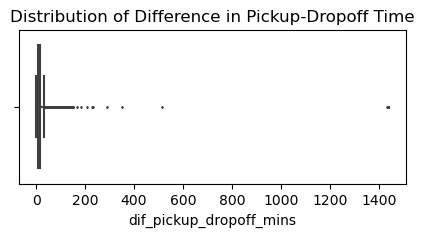

In [27]:
plt.figure(figsize=(5,2))
sns.boxplot(x=no_passenger_df['dif_pickup_dropoff_mins'], fliersize = 1)
plt.title('Distribution of Difference in Pickup-Dropoff Time')
plt.show()

In [28]:
taxi_filtered_df['passenger_count'].value_counts()

passenger_count
1    8494328
2    1757979
3     461673
5     418225
6     245808
4     224672
0     222229
7         51
8         32
9         26
Name: count, dtype: int64

In [29]:
no_passenger_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,222229,222229,222229.0,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.0,222229.000000
mean,2020-01-30 20:40:35.254732800,2020-01-30 20:53:15.764751616,0.0,2.639580,1.134154,165.118108,163.276112,1.290412,12.131895,2.624917,0.495576,2.127231,0.298035,0.299707,17.982164,2.301162,2020.0,12.675167
min,2020-01-01 00:00:05,2020-01-01 00:09:20,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,-225.500000,0.000000,-0.500000,0.000000,0.000000,-0.300000,-228.800000,-2.500000,2020.0,0.000000
25%,2020-01-16 22:52:40,2020-01-16 23:05:26,0.0,0.900000,1.000000,132.000000,113.000000,1.000000,6.000000,2.500000,0.500000,0.000000,0.000000,0.300000,10.800000,2.500000,2020.0,6.033333
50%,2020-01-31 10:15:17,2020-01-31 10:30:00,0.0,1.500000,1.000000,162.000000,162.000000,1.000000,8.500000,2.500000,0.500000,1.850000,0.000000,0.300000,14.100000,2.500000,2020.0,10.083333
75%,2020-02-13 14:37:12,2020-02-13 14:51:07,0.0,2.700000,1.000000,234.000000,234.000000,2.000000,13.000000,3.000000,0.500000,2.780000,0.000000,0.300000,18.960000,2.500000,2020.0,16.250000
max,2020-07-28 09:02:59,2020-07-28 09:08:19,0.0,93.500000,99.000000,265.000000,265.000000,4.000000,428.500000,7.000000,3.300000,309.730000,93.500000,0.300000,435.420000,2.500000,2020.0,1439.366667
std,NaN,NaN,0.0,3.550434,2.597158,64.936563,69.206114,0.520903,11.386968,0.836462,0.050319,2.791150,1.569106,0.010395,13.834174,0.677014,0.0,13.866527


There are 222229 rows that are filled with zero passenger in a trip. This represents 1.87% of the total data set.
We have look for possible patterns in the data that could explain this casuistic.
First we looked at the total amount charged to customers and we saw that there is not a usual amount charged. We also looked at the trip time as we thought we could see patterns in the hours or the minutes per trip. It is true that the average trip is around 12.5 minutes (short trips in a city like New York) but invesitigating other variables we did not see a direct connection.
We also visualize how data was distributed as we could saw possible outliers and data that might not be correctly inputed in the data set. 

Taking into account this analysis and the possible explanations of having trips with zero passengers (cancelled trips, forgotten items, very short trips, etc.) we have decided to drop the rows with  zero passengers.

For the future purposes of the analysis we think it would lead to more inneficient results than efficieint.

In [30]:
# dropping passenger count = 0 from the dataframe
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['passenger_count'] != 0]

In [31]:
# checking if passenger count = 0 was succesfully dropped
taxi_filtered_df['passenger_count'].value_counts()

passenger_count
1    8494328
2    1757979
3     461673
5     418225
6     245808
4     224672
7         51
8         32
9         26
Name: count, dtype: int64

In [32]:
taxi_filtered_df.describe(include='all')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,11602794,11602794,11602794,1.160279e+07,1.160279e+07,1.160279e+07,11602794,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,11602794.0,1.160279e+07
unique,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7923662,NaN,NaN,NaN,NaN,NaN,11486670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2020-01-30 01:01:18.894498304,2020-01-30 01:17:16.998491904,1.539354e+00,2.827798e+00,1.056904e+00,NaN,1.649577e+02,1.629427e+02,1.264571e+00,1.248948e+01,1.066790e+00,4.937787e-01,2.225409e+00,3.288314e-01,2.979076e-01,1.847580e+01,2.303020e+00,2020.0,1.596840e+01
min,NaN,2020-01-01 00:00:00,2020-01-01 00:01:17,1.000000e+00,-2.218000e+01,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,-1.238000e+03,-2.700000e+01,-5.000000e-01,-9.300000e+01,-3.823000e+01,-3.000000e-01,-1.242300e+03,-2.500000e+00,2020.0,-9.990667e+03
25%,NaN,2020-01-16 07:39:06,2020-01-16 07:53:20,1.000000e+00,9.600000e-01,1.000000e+00,NaN,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,2020.0,6.433333e+00
50%,NaN,2020-01-30 09:10:56,2020-01-30 09:27:53,1.000000e+00,1.600000e+00,1.000000e+00,NaN,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,2020.0,1.056667e+01
75%,NaN,2020-02-12 19:02:18,2020-02-12 19:17:24,2.000000e+00,2.890000e+00,1.000000e+00,NaN,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.940000e+00,0.000000e+00,3.000000e-01,1.975000e+01,2.500000e+00,2020.0,1.690000e+01
max,NaN,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,3.699400e+02,9.900000e+01,NaN,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,4.268300e+03,2.750000e+00,2020.0,8.525117e+03


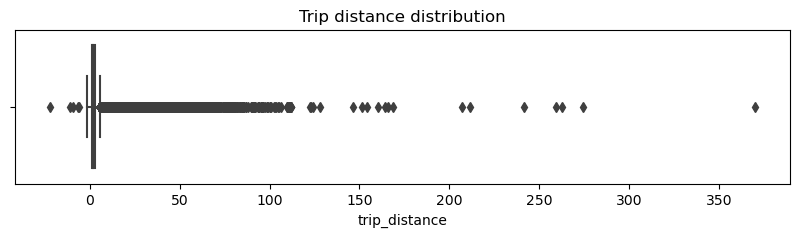

In [33]:
# 2. Trip distance
# Visualizing distribution
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['trip_distance'])
plt.title('Trip distance distribution')
plt.show()

As shown in the boxplot we have negative values and outliers. 

Negative trip distances does not make sense so we will drop them from the data. Later we will handle outliers.

In [34]:
# Handling negative values
negative_trip_distance_df = taxi_filtered_df[taxi_filtered_df['trip_distance']< 0]

In [35]:
negative_trip_distance_df['trip_distance'].value_counts()

trip_distance
-0.88     2
-0.71     1
-9.29     1
-1.79     1
-22.18    1
-1.25     1
-1.32     1
-1.48     1
-6.33     1
-10.94    1
-1.44     1
-6.40     1
Name: count, dtype: int64

In [36]:
negative_trip_distance_df['trip_distance'].count().sum()

13

In [37]:
# Dropping values trip_distance < 0 
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['trip_distance']>=0]
# Checking that values are successfully dropped
taxi_filtered_df[taxi_filtered_df['trip_distance']< 0].count().sum()

0

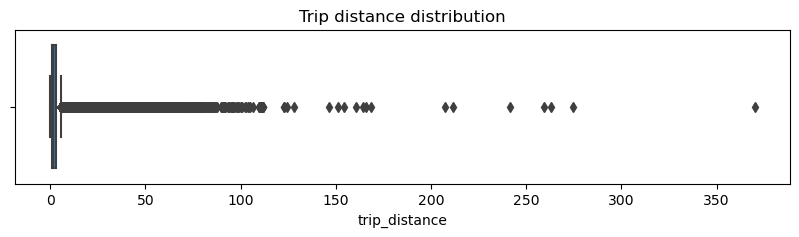

In [38]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['trip_distance'])
plt.title('Trip distance distribution')
plt.show()

In [51]:
taxi_filtered_df.groupby('trip_distance')['trip_distance'].count()

trip_distance
0.00      117074
0.01        6429
0.02        4615
0.03        3659
0.04        2932
           ...  
241.64         1
259.22         1
262.88         1
274.50         1
369.94         1
Name: trip_distance, Length: 4995, dtype: int64

We can observ that there are trip distances equal to zero o very near. As there are still some varibles we want to clean that can be connected with trip distance we are not going to do anything but after checking all the variables we will review the number and see if we need to put a threshold and drop some values. 

We have decided to take this decision as it may happen that some trips are cancelled but still charged to the customer for example and it's a really low amount of occurencies from all the data.

In [55]:
# handling outliers (long distances)
# We are going to handle outliers taking into consideration what is academically considered an outlier 1.5+-IQR.
# We could have put a threshold but as data seems not official we prefer to go for an academic approach.

# quantile 0.75
percentile_75 = taxi_filtered_df['trip_distance'].quantile(0.75)
print('Percintile 75%: ', percentile_75)

# IQR 
iqr = round(percentile_75 - percentile_25, 2) 
print('IQR: ', iqr)

# upper limit
upper_limit = percentile_75 + 1.5 * iqr
print('Upper limit: ', upper_limit)

# defining outliers in hr_df1
outliers = taxi_filtered_df[taxi_filtered_df['trip_distance']> upper_limit]


Percintile 75%:  2.89
IQR:  1.93
Upper limit:  5.785


Knowing this values and having identified outliers it would be interesting to see how many of this
outliers we do have in the data set. Pulling how many rows we can see the impact of this outliers.

In [59]:
# pulling outliers rows
print('# of rows with outliers in trip distance:', len(outliers))
print()
print(f'% of outliers in trip distance against total: {round(len(outliers)/len(taxi_filtered_df)*100, 2)}%')

# of rows with outliers in trip distance: 1282763

% of outliers in trip distance against total: 11.06%
